In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from EMG_Step_Extr_Pipeline import EMGProcessor
import pandas as pd

from Data_Segmentation import Data_Segmentor
from Step_Extraction_Stats import Step_Extraction_Stats
import math
from datetime import datetime
import os

from sklearn.manifold import TSNE
from scipy import interpolate
from itertools import chain



# Loading All Dataframe CSV files

In [2]:
inputDfDict = {}
directory = './'

csv_files_emg = [f for f in os.listdir(directory) if f.endswith('emg.csv') and f.startswith('trial')]
csv_files_press = [f for f in os.listdir(directory) if f.endswith('press.csv') and f.startswith('trial')]

print(csv_files_emg)
print(csv_files_press)

['trial5_upstairs_emg.csv', 'trial7_flat2_emg.csv', 'trial5_uneven1_emg.csv', 'trial4_flat2_emg.csv', 'trial4_uneven2_emg.csv', 'trial5_uneven2_emg.csv', 'trial7_flat1_emg.csv', 'trial4_upstairs_emg.csv', 'trial5_downstairs_emg.csv', 'trial4_uneven1_emg.csv', 'trial4_flat1_emg.csv', 'trial7_uneven2_emg.csv', 'trial7_downstairs_emg.csv', 'trial7_upstairs_emg.csv', 'trial5_flat1_emg.csv', 'trial4_downstairs_emg.csv', 'trial5_flat2_emg.csv', 'trial7_uneven1_emg.csv']
['trial7_upstairs_press.csv', 'trial7_uneven1_press.csv', 'trial5_flat2_press.csv', 'trial7_flat1_press.csv', 'trial4_upstairs_press.csv', 'trial5_uneven1_press.csv', 'trial7_downstairs_press.csv', 'trial4_flat2_press.csv', 'trial4_uneven1_press.csv', 'trial5_uneven2_press.csv', 'trial4_flat1_press.csv', 'trial4_uneven2_press.csv', 'trial4_downstairs_press.csv', 'trial7_uneven2_press.csv', 'trial5_upstairs_press.csv', 'trial5_downstairs_press.csv', 'trial7_flat2_press.csv', 'trial5_flat1_press.csv']


In [3]:
# Loading all of the emg dataframes into one dictionary
dataframesEMG = {}
for file in csv_files_emg:
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path)
    dataframesEMG[file[0:len(file) -8]] = df

# Loading all of the press dataframes into one dictionary
dataframesPress = {}
for file in csv_files_press:
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path)
    dataframesPress[file[0:len(file) - 10]] = df

In [4]:
dataframesPress.keys()

dict_keys(['trial7_upstairs', 'trial7_uneven1', 'trial5_flat2', 'trial7_flat1', 'trial4_upstairs', 'trial5_uneven1', 'trial7_downstairs', 'trial4_flat2', 'trial4_uneven1', 'trial5_uneven2', 'trial4_flat1', 'trial4_uneven2', 'trial4_downstairs', 'trial7_uneven2', 'trial5_upstairs', 'trial5_downstairs', 'trial7_flat2', 'trial5_flat1'])

# Iterating Through All Terrain Dataframes and Trials to Extract Steps

In [4]:
# Step extraction for Trial 4
stepExtrDataframesR = {}
stepExtrDataframesL = {}

binR = "RearfootR"
binL = "RearfootL"
    
stepExtr = Step_Extraction_Stats()

# Extracting the steps for each terrain and trial
for key in dataframesEMG.keys():
    stepExtrDataframesR[key] = stepExtr.extract_steps(dataframesPress[key], dataframesEMG[key], binR)

    stepExtrDataframesL[key] = stepExtr.extract_steps(dataframesPress[key], dataframesEMG[key], binL)



# Running a TSNE for All Terrains for Each Sensor

In [5]:

"""
This function downsamples the emg steps to make them all the same length.
"""
def downsample_signal(signal, targetLength):
    originalIndices = np.linspace(0, len(signal) - 1, num=len(signal))
    targetIndices = np.linspace(0, len(signal) - 1, num=targetLength)
    
    interpolation_function = interpolate.interp1d(
        originalIndices, 
        signal, 
        kind='linear'  
    )
    
    downsampled_signal = interpolation_function(targetIndices)
    return downsampled_signal

In [6]:
# Need to normalize all signals to their MVC in the future, won't do for now

# Parsing trial dataframes into the specific terrains.
unevenDictL = {}
flatDictL = {}
upstairsDictL = {}
downstairsDictL = {}

unevenDictR = {}
flatDictR = {}
upstairsDictR = {}
downstairsDictR = {}

for key in stepExtrDataframesL.keys():
    if ("uneven" in key):
        unevenDictL[key] = stepExtrDataframesL[key]

    elif ("upstairs" in key):
        upstairsDictL[key] = stepExtrDataframesL[key]

    elif ("downstairs" in key):
        downstairsDictL[key] = stepExtrDataframesL[key]

    else:
        flatDictL[key] = stepExtrDataframesL[key]
                                             
                                        
for key in stepExtrDataframesR.keys():
    if ("uneven" in key):
        unevenDictR[key] = stepExtrDataframesR[key]

    elif ("upstairs" in key):
        upstairsDictR[key] = stepExtrDataframesR[key]

    elif ("downstairs" in key):
        downstairsDictR[key] = stepExtrDataframesR[key]

    else:
        flatDictR[key] = stepExtrDataframesR[key]
        

In [33]:
"""
Steps for parsing dataframes to put into TSNE by muscle

1. Go through all the different terrain dataframes, find the minimum length array among each of the steps.
2. Use this minimum length to downsample all arrays to the same size.
3. concat all data into one dataframe by column, saving a label array that corresponds to all the terrains.
4. 0 is for flat terrain, 1 is for uneven terrain, 2 is for upstairs, 3 is for downstairs.
"""

minArrayLength = np.inf

# Finding the minimum length array
for key in stepExtrDataframesL.keys():
    if (len(stepExtrDataframesL[key]["TAL"][0]) < minArrayLength):
        minArrayLength = len(stepExtrDataframesL[key]["TAL"][0])
print(minArrayLength)

# Downsample all the arrays to the minimum size to make all the combined dataframes
newDict = {}
for key in stepExtrDataframesL.keys():
    currDf = stepExtrDataframesL[key]
    dfCols = currDf.columns

    uniformDfDict = {}
    for col in dfCols:
        signals = currDf[col].to_numpy()

        uniformDfDict[col] = [downsample_signal(signal, minArrayLength) for signal in signals]

    newDict[key] = pd.DataFrame.from_dict(uniformDfDict)

print(newDict.keys())

# Concatenate all data into one dataframe that contains all data across terrains and trials for each muscle
# and create the labelArr
labelArrL = np.array([])
terrainArrL = []
allTerrainDfL = pd.DataFrame()

for key in newDict.keys():
    if ("flat" in key):
        terrainArrL.append(["f"]*len(newDict[key]["TAL"]))
        labelArrL = np.append(labelArrL, np.zeros(len(newDict[key]["TAL"])), axis = 0)
        allTerrainDfL = pd.concat([allTerrainDfL, newDict[key]], ignore_index=True)

    elif ("uneven" in key):
        terrainArrL.append(["un"]*len(newDict[key]["TAL"]))
        labelArrL = np.append(labelArrL, np.ones(len(newDict[key]["TAL"])), axis = 0)
        allTerrainDfL = pd.concat([allTerrainDfL, newDict[key]], ignore_index=True)

    elif ("upstairs" in key):
        terrainArrL.append(["up"]*len(newDict[key]["TAL"]))
        labelArrL = np.append(labelArrL, np.ones(len(newDict[key]["TAL"]))*2, axis = 0)
        allTerrainDfL = pd.concat([allTerrainDfL, newDict[key]], ignore_index=True)

    else:
        terrainArrL.append(["down"]*len(newDict[key]["TAL"]))
        labelArrL = np.append(labelArrL, np.ones(len(newDict[key]["TAL"]))*3, axis = 0)
        allTerrainDfL = pd.concat([allTerrainDfL, newDict[key]], ignore_index=True)



1035
dict_keys(['trial5_upstairs', 'trial7_flat2', 'trial5_uneven1', 'trial4_flat2', 'trial4_uneven2', 'trial5_uneven2', 'trial7_flat1', 'trial4_upstairs', 'trial5_downstairs', 'trial4_uneven1', 'trial4_flat1', 'trial7_uneven2', 'trial7_downstairs', 'trial7_upstairs', 'trial5_flat1', 'trial4_downstairs', 'trial5_flat2', 'trial7_uneven1'])


In [52]:
labelArrL

array([2., 2., 2., 2., 2., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2., 2., 3., 3., 3., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 3.,
       3., 3., 2., 2., 2., 2., 2., 2., 2., 0., 0., 0., 0., 0., 3., 3., 3.,
       3., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.])

In [60]:
"""
Steps for parsing dataframes to put into TSNE by muscle

1. Go through all the different terrain dataframes, find the minimum length array among each of the steps.
2. Use this minimum length to downsample all arrays to the same size.
3. concat all data into one dataframe by column, saving a label array that corresponds to all the terrains.
4. 0 is for flat terrain, 1 is for uneven terrain, 2 is for upstairs, 3 is for downstairs.
"""

minArrayLength = np.inf

# Finding the minimum length array
for key in stepExtrDataframesR.keys():
    if (len(stepExtrDataframesR[key]["TAR"][0]) < minArrayLength):
        minArrayLength = len(stepExtrDataframesR[key]["TAR"][0])
print(minArrayLength)

# Downsample all the arrays to the minimum size to make all the combined dataframes
newDict = {}
for key in stepExtrDataframesR.keys():
    currDf = stepExtrDataframesR[key]
    dfCols = currDf.columns

    uniformDfDict = {}
    for col in dfCols:
        signals = currDf[col].to_numpy()

        uniformDfDict[col] = [downsample_signal(signal, minArrayLength) for signal in signals]

    newDict[key] = pd.DataFrame.from_dict(uniformDfDict)

print(newDict.keys())

# Concatenate all data into one dataframe that contains all data across terrains and trials for each muscle
# and create the labelArr
labelArrR = np.array([])
terrainArrR = []
allTerrainDfR = pd.DataFrame()

for key in newDict.keys():
    if ("flat" in key):
        terrainArrR.append(["f"]*len(newDict[key]["TAR"]))
        labelArrR = np.append(labelArrR, np.zeros(len(newDict[key]["TAR"])), axis = 0)
        allTerrainDfR = pd.concat([allTerrainDfR, newDict[key]], ignore_index=True)

    elif ("uneven" in key):
        print(np.ones(len(newDict[key]["TAR"])))
        terrainArrR.append(["un"]*len(newDict[key]["TAR"]))
        labelArrR = np.append(labelArrR, np.ones(len(newDict[key]["TAR"])), axis = 0)
        allTerrainDfR = pd.concat([allTerrainDfR, newDict[key]], ignore_index=True)

    elif ("upstairs" in key):
        terrainArrR.append(["up"]*len(newDict[key]["TAR"]))
        labelArrR = np.append(labelArrR, np.ones(len(newDict[key]["TAR"]))*2, axis = 0)
        allTerrainDfR = pd.concat([allTerrainDfR, newDict[key]], ignore_index=True)

    else:
        terrainArrR.append(["down"]*len(newDict[key]["TAR"]))
        labelArrR = np.append(labelArrR, np.ones(len(newDict[key]["TAR"]))*3, axis = 0)
        allTerrainDfR = pd.concat([allTerrainDfR, newDict[key]], ignore_index=True)


628
dict_keys(['trial5_upstairs', 'trial7_flat2', 'trial5_uneven1', 'trial4_flat2', 'trial4_uneven2', 'trial5_uneven2', 'trial7_flat1', 'trial4_upstairs', 'trial5_downstairs', 'trial4_uneven1', 'trial4_flat1', 'trial7_uneven2', 'trial7_downstairs', 'trial7_upstairs', 'trial5_flat1', 'trial4_downstairs', 'trial5_flat2', 'trial7_uneven1'])
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]


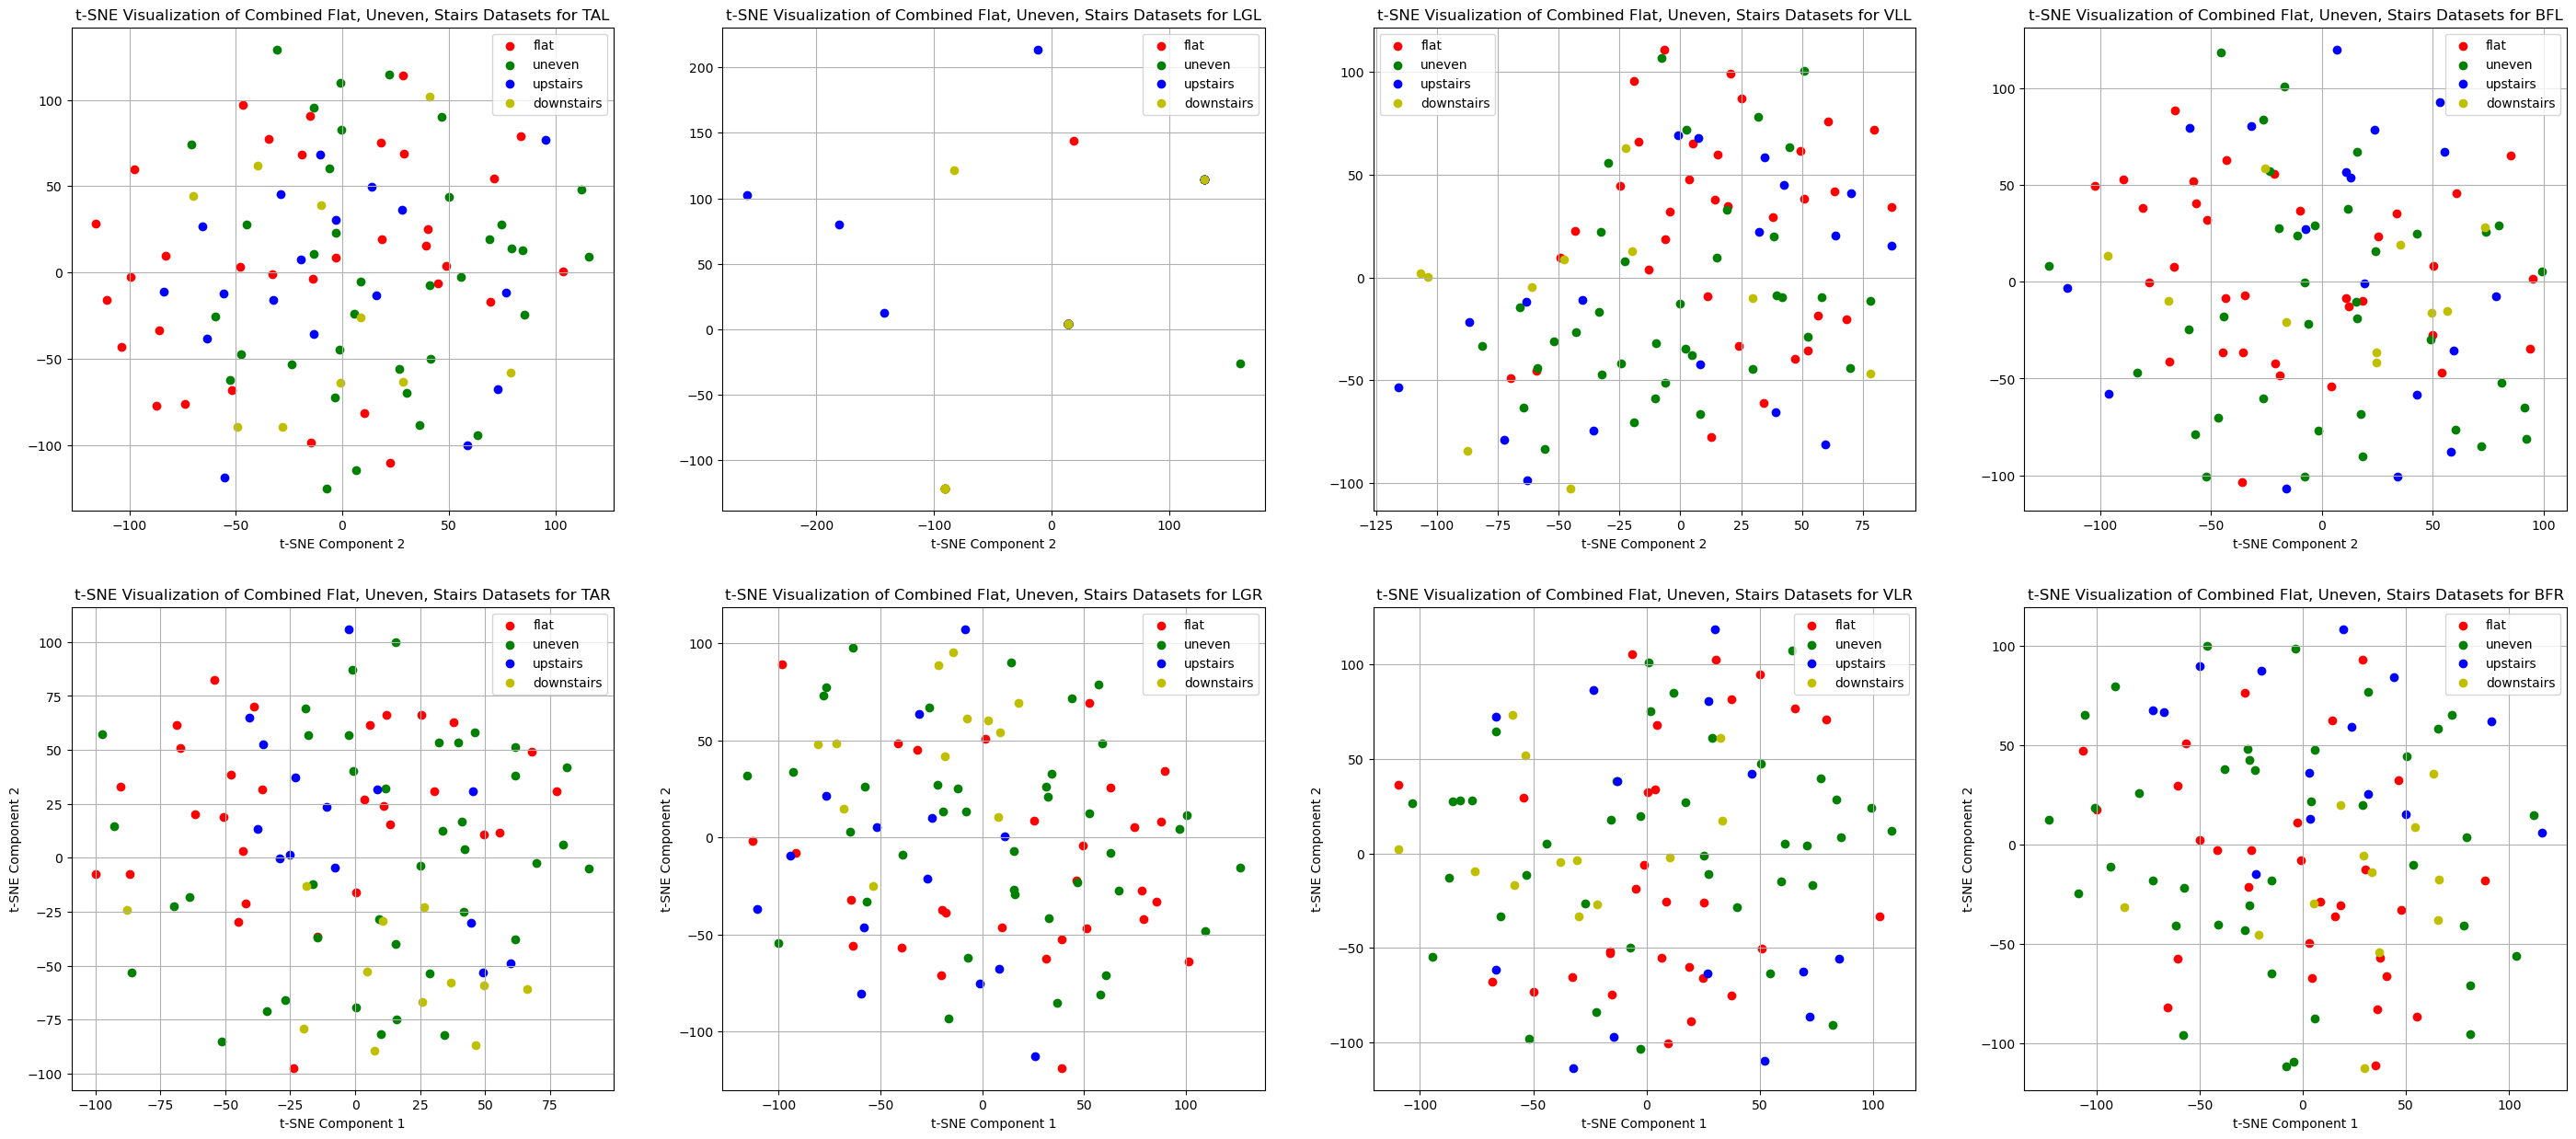

In [69]:
inputDfL = allTerrainDfL
inputDfR = allTerrainDfR

combinedCols = inputDfL.columns.values
combinedCols = np.append(combinedCols, inputDfR.columns.values)

i,j=0,0
PLOTS_PER_ROW = 4
fig, axs = plt.subplots(2,PLOTS_PER_ROW, figsize=(35, 15))
iter = 0

for col in combinedCols:
    if (col[len(col) - 1:len(col)] == "L"):
        subset = inputDfL[col].to_numpy()

        X = np.stack(subset)
        y = labelArrL
        attachments = [j for sub in terrainArrL for j in sub]

        # Initialize t-SNE with desired parameters
        tsne = TSNE(n_components=3, perplexity=22, random_state=42)

        # Fit and transform the data to lower dimensions
        X_tsne = tsne.fit_transform(X)

        # Visualize the t-SNE representation
        #fig = plt.figure(figsize=(8, 6))
        #ax = fig.add_subplot(111)

        # Plot each class with a different color
        labels = ["flat", "uneven", "upstairs", "downstairs"]

        for x, c in zip(np.unique(y), ['r', 'g', 'b', 'y']):
            #print(i)
            axs[i][j].scatter(X_tsne[y == x, 0], X_tsne[y == x, 1], c=c, label=f'{labels[int(x)]}')

        axs[i][j].set_title('t-SNE Visualization of Combined Flat, Uneven, Stairs Datasets for {}'.format(col))
        axs[i][j].set_xlabel('t-SNE Component 1')
        axs[i][j].set_ylabel('t-SNE Component 2')
        axs[i][j].legend()
        axs[i][j].grid(True)

    else:
        subset = inputDfR[col].to_numpy()
        #print(len(subset))
        X = np.stack(subset)
        #print(len(X))
        y = labelArrR
        attachments = [j for sub in terrainArrR for j in sub]

        # Initialize t-SNE with desired parameters
        tsne = TSNE(n_components=3, perplexity=22, random_state=42)

        # Fit and transform the data to lower dimensions
        X_tsne = tsne.fit_transform(X)
        #print(X_tsne.shape)
        # Visualize the t-SNE representation

        # Plot each class with a different color
        labels = ["flat", "uneven", "upstairs", "downstairs"]
        test1 = X_tsne[y == 0.0, 0]
        test2 = X_tsne[y == 0.0, 1]
        for z, c in zip(np.unique(y), ['r', 'g', 'b', 'y']):
            #print(x)
            axs[i][j].scatter(X_tsne[y == z, 0], X_tsne[y == z, 1], c=c, label=f'{labels[int(z)]}')

        axs[i][j].set_title('t-SNE Visualization of Combined Flat, Uneven, Stairs Datasets for {}'.format(col))
        axs[i][j].set_xlabel('t-SNE Component 1')
        axs[i][j].set_ylabel('t-SNE Component 2')
        axs[i][j].legend()
        axs[i][j].grid(True)

    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
    iter += 1

plt.show()